<a href="https://colab.research.google.com/github/riezaferdi/B21-CAP0261/blob/main/colab_master/Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
print(tensorflow.__version__)

2.5.0


# Import

In [2]:
import os
import zipfile
import random
import tensorflow as tf
import pathlib
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import shutil

# For clearing folder if necessary

In [3]:
#USE THIS BLOCK CODE IF NECESSARY
try:
  shutil.rmtree('/tmp/dataset_hsxy/')
  shutil.rmtree('/tmp/dataset_hsxy_splitted/')
except OSError:
    pass

# Pre processing

In [4]:
#!wget --no-check-certificate \
#    "https://drive.google.com/file/d/1xqW25CtUd_Li8yeirRiIhMuWUuUr1Aj4/view" \
#    -O "/tmp/dataset-hsxy.zip"

#local_zip = '/tmp/dataset-hsxy.zip'
local_zip = '/content/drive/MyDrive/dataset_hsxy.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
print(len(os.listdir('/tmp/dataset_hsxy/health/')))
print(len(os.listdir('/tmp/dataset_hsxy/s/')))
print(len(os.listdir('/tmp/dataset_hsxy/x/')))
print(len(os.listdir('/tmp/dataset_hsxy/y/')))

# Expected Output:
# 12501
# 12501

100
7
12
14


In [6]:
try:
    #os.mkdir('/tmp/dataset_hsxy')
    os.mkdir('/tmp/dataset_hsxy/training')
    os.mkdir('/tmp/dataset_hsxy/testing')
    os.mkdir('/tmp/dataset_hsxy/training/health')
    os.mkdir('/tmp/dataset_hsxy/training/s')
    os.mkdir('/tmp/dataset_hsxy/training/x')
    os.mkdir('/tmp/dataset_hsxy/training/y')
    os.mkdir('/tmp/dataset_hsxy/testing/health')
    os.mkdir('/tmp/dataset_hsxy/testing/s')
    os.mkdir('/tmp/dataset_hsxy/testing/x')
    os.mkdir('/tmp/dataset_hsxy/testing/y')
except OSError:
    pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


HEALTH_SOURCE_DIR = "/tmp/dataset_hsxy/health/"
TRAINING_HEALTH_DIR = "/tmp/dataset_hsxy/training/health/"
TESTING_HEALTH_DIR = "/tmp/dataset_hsxy/testing/health/"
S_SOURCE_DIR = "/tmp/dataset_hsxy/s/"
TRAINING_S_DIR = "/tmp/dataset_hsxy/training/s/"
TESTING_S_DIR = "/tmp/dataset_hsxy/testing/s/"
X_SOURCE_DIR = "/tmp/dataset_hsxy/x/"
TRAINING_X_DIR = "/tmp/dataset_hsxy/training/x/"
TESTING_X_DIR = "/tmp/dataset_hsxy/testing/x/"
Y_SOURCE_DIR = "/tmp/dataset_hsxy/y/"
TRAINING_Y_DIR = "/tmp/dataset_hsxy/training/y/"
TESTING_Y_DIR = "/tmp/dataset_hsxy/testing/y/"

split_size = .8
split_data(HEALTH_SOURCE_DIR, TRAINING_HEALTH_DIR, TESTING_HEALTH_DIR, split_size)
split_data(S_SOURCE_DIR, TRAINING_S_DIR, TESTING_S_DIR, split_size)
split_data(X_SOURCE_DIR, TRAINING_X_DIR, TESTING_X_DIR, split_size)
split_data(Y_SOURCE_DIR, TRAINING_Y_DIR, TESTING_Y_DIR, split_size)

In [8]:
print(len(os.listdir('/tmp/dataset_hsxy/training/health/')))
print(len(os.listdir('/tmp/dataset_hsxy/training/s/')))
print(len(os.listdir('/tmp/dataset_hsxy/training/x/')))
print(len(os.listdir('/tmp/dataset_hsxy/training/y/')))
print(len(os.listdir('/tmp/dataset_hsxy/testing/health/')))
print(len(os.listdir('/tmp/dataset_hsxy/testing/s/')))
print(len(os.listdir('/tmp/dataset_hsxy/testing/x/')))
print(len(os.listdir('/tmp/dataset_hsxy/testing/y/')))

80
5
9
11
20
2
3
3


# Augmentation

In [9]:
TRAINING_DIR = "/tmp/dataset_hsxy/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='sparse',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/dataset_hsxy/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='sparse',
                                                              target_size=(150, 150))

Found 105 images belonging to 4 classes.
Found 28 images belonging to 4 classes.


#  Train

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/20
2/2 [==============================] - 10s 7s/step - loss: 5.4934 - accuracy: 0.7619 - val_loss: 2.1433 - val_accuracy: 0.7143
Epoch 2/20
2/2 [==============================] - 7s 1s/step - loss: 1.8388 - accuracy: 0.7333 - val_loss: 2.0544 - val_accuracy: 0.1071
Epoch 3/20
2/2 [==============================] - 7s 1s/step - loss: 1.8218 - accuracy: 0.1333 - val_loss: 0.8690 - val_accuracy: 0.7143
Epoch 4/20
2/2 [==============================] - 7s 2s/step - loss: 0.7217 - accuracy: 0.7619 - val_loss: 0.9637 - val_accuracy: 0.7143
Epoch 5/20
2/2 [==============================] - 7s 1s/step - loss: 0.7298 - accuracy: 0.7619 - val_loss: 0.7577 - val_accuracy: 0.7143
Epoch 6/20
2/2 [==============================] - 7s 6s/step - loss: 0.8310 - accuracy: 0.8190 - val_loss: 0.7258 - val_accuracy: 0.8571
Epoch 7/20
2/2 [==============================] - 7s 6s/step - loss: 0.5568 - accuracy: 0.8095 - val_loss: 0.7734 - val_accuracy: 0.7143
Epoch 8/20
2/2 [========================

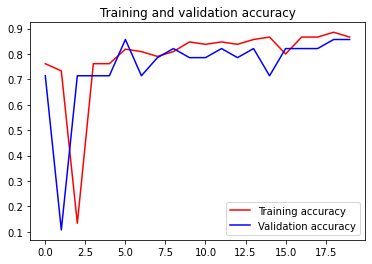

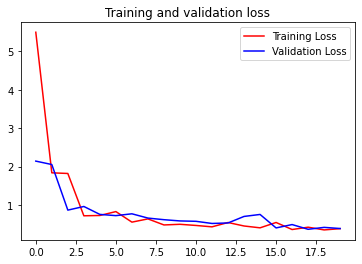

In [11]:
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=validation_generator)

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Convert to TFLite

In [12]:
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/1/assets


In [13]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [optimization]

tflite_model = converter.convert()

In [15]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

42516656

# make .txt

In [16]:
f = open("./label.txt","w+")
f.write("health\nx\ny\ns")
f.close() 